In [313]:
import praw
import pandas as pd
import datetime
import time
from bs4 import BeautifulSoup
import requests
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from itertools import islice
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import plotly.graph_objects as go

In [2]:

class SubredditStats:
    def __init__(self, name, data = None):
        self._name = name
        self._url = 'https://subredditstats.com/r/{}'.format(self._name)
        if data is None:
          self._data = self._query(self._url)
        else:
          self._data = data

    def _query(self, url):
        req = requests.get(url)
        soup = BeautifulSoup(req.content, 'html.parser')
        return json.loads(soup.find('script', {'id': 'embeddedSubredditData'}).text)


    def _time_series(self, series_type, value_name):
        day_to_sec = lambda day: day * 24 * 60 * 60
        sorted_values = list(sorted(self._data[series_type], key=lambda d: int(d['utcDay'])))
        sorted_seconds = [{'utcDay': day_to_sec(d['utcDay']), 'count': d[value_name]} for d in sorted_values]
        return sorted_seconds

    def avg_subsribers_per_day(self):
        spd = self.subscriber_count_time_series()
        return (spd[-1]['count'] - spd[0]['count']) / (spd[-1]['utcDay'] / 24 / 60 / 60 - spd[0]['utcDay'] / 24 / 60 / 60)

    def avg_posts_per_day(self):
        ppd = self.posts_per_day_time_series()
        return (ppd[-1]['count'] - ppd[0]['count']) / (ppd[-1]['utcDay'] / 24 / 60 / 60 - ppd[0]['utcDay'] / 24 / 60 / 60)


    @property
    def name(self):
        return self._name

    def subscriber_count_time_series(self):
        return self._time_series('subscriberCountTimeSeries', 'count')

    def posts_per_day_time_series(self):
        return self._time_series('postsPerHourTimeSeries', 'postsPerHour')

    def comments_per_day_rank_time_series(self):
        return self._time_series('commentsPerHourRankTimeSeries', 'rank')

    def comments_per_day_time_series(self):
        return self._time_series('commentsPerHourTimeSeries', 'commentsPerHour')

    def n_subscribers(self):
        return self._data['subscriberCount']

    def subscribers_rank(self):
        return self._data['subscriberCountRank']

    def posts_per_subscriber(self):
        return self._data['postsPerSubscriber']

    def posts_per_hour(self):
        return self._data['postsPerHour']

    def posts_per_hour_rank(self):
        return self._data['postsPerHourRank']

    def mentions_per_day(self):
        return self._data['mentionsPerDay']

    def mentions_per_day_rank(self):
        return self._data['mentionsPerDayRank']

    def creation_time(self):
        return self._data['creationTime']

    def description(self):
        return self._data['description']

    def comments_per_subscriber(self):
        return self._data['commentsPerSubscriber']

    def comments_per_subscriber_rank(self):
        return self._data['commentsPerSubscriberRanked']

    def comments_per_hour(self):
        return self._data['commentsPerHour']

    def comments_per_hour_rank(self):
        return self._data['commentsPerHourRank']

    def top_commenters_by_frequency(self):
        return self._data['topCommentersByFrequency']

    def top_commenters_by_score_sum(self):
        return self._data['topCommentersByScoreSum']

    def top_keywords(self):
        return self._data['topKeywords']

    def top_linked_domains(self):
        return self._data['topLinkedDomains']

    def top_posters_by_frequency(self):
        return self._data['topPostersByFrequency']

    def top_posters_by_score_sum(self):
        return self._data['topPostersByScoreSum']

    def top_posts_comments_sum(self):
        return self._data['topPostsCommentsSum']

    def top_posts_comments_sum_rank(self):
        return self._data['topPostsCommentsSumRank']

    def top_posts_gilded_sum(self):
        return self._data['topPostsGildedSum']

    def top_posts_gilded_sum_rank(self):
        return self._data['topPostsGildedSumRank']

    def top_posts_score_sum(self):
        return self._data['topPostsScoreSum']

    def top_posts_score_sum_rank(self):
        return self._data['topPostsScoreSumRank']

    def comments_per_subscriber_rank(self):
        return self._data['commentsPerSubscriberRank']

    def posts_per_subscriber_rank(self):
        return self._data['postsPerSubscriberRank']

    def gilds_per_subscriber(self):
        return self._data['gildsPerSubscriber']

    def gilds_per_subscriber_rank(self):
        return self._data['gildsPerSubscriberRank']

    def subreddit_id(self):
        return self._data['subredditId']

    def quarantined(self):
        return self._data['quarantined']

    def is_active_subreddit(self):
        return self._data['isActiveSubreddit']



In [4]:
subreddits_stats = {}
with open('output/data.json', 'r') as json_file:
  json_data = json.load(json_file)
  for item in tqdm(json_data):
    subreddit_name = item['subreddit_name']
    subreddit_data = item['data']
    subreddits_stats[subreddit_name] = SubredditStats(subreddit_name, subreddit_data)

100%|██████████| 1074/1074 [00:00<00:00, 336245.61it/s]


In [5]:

def posts_per_day(reddit_stat):
    ppd = reddit_stat.posts_per_day_time_series()
    days = {}
    for post_day in ppd:
        day = int(post_day['utcDay'] / 24 / 60 / 60)
        days[day] = post_day['count']
    return days

def subsribers_per_day(reddit_stat):
    ppd = reddit_stat.subscriber_count_time_series()
    days = {}
    for post_day in ppd:
        day = int(post_day['utcDay'] / 24 / 60 / 60)
        days[day] = post_day['count']
    return days

def comments_per_day(reddit_stat):
    cpd = reddit_stat.comments_per_day_time_series()
    days = {}
    for post_day in cpd:
        day = int(post_day['utcDay'] / 24 / 60 / 60)
        days[day] = post_day['count']
    return days

def growth_per_day(reddit_stat):
    ppd = reddit_stat.subscriber_count_time_series()
    days = {}
    for index, post_day in enumerate(ppd):
        today_day = int(post_day['utcDay'] / 24 / 60 / 60)
        today_count = post_day['count']
        if index == 0:
            days[today_day] = 0
            continue
        prev_day = int(ppd[index - 1]['utcDay'] / 24 / 60 / 60)
        prev_day_count = ppd[index - 1]['count']
        if today_day - prev_day == 0 or prev_day_count == 0:
            continue
            
        growth = ((today_count - prev_day_count) / prev_day_count) / (today_day - prev_day)
        days[today_day] = growth
    return days

def wighted_growth_per_day(reddit_stat, factor):
    ppd = reddit_stat.subscriber_count_time_series()
    days = {}
    for index, post_day in enumerate(ppd):
        today_day = int(post_day['utcDay'] / 24 / 60 / 60)
        today_count = post_day['count']
        if index == 0:
            days[today_day] = 0
            continue
        prev_day = int(ppd[index - 1]['utcDay'] / 24 / 60 / 60)
        prev_day_count = ppd[index - 1]['count']
        if today_day - prev_day == 0 or prev_day_count == 0:
            continue            
        growth = (((today_count - prev_day_count) / prev_day_count) / (today_day - prev_day)) * (factor ** (index + 1))
        days[today_day] = growth
    return days

def posts_per_week(reddit_stat):
    weeks = {}
    days = posts_per_day(reddit_stat)
    for day in days:
        week = int(day / 7)
        if week not in weeks:
            weeks[week] = 0
        weeks[week] += days[day]
    return weeks

def subsribers_per_week(reddit_stat):
    weeks = {}
    days = subsribers_per_day(reddit_stat)
    for day in days:
        week = int(day / 7)
        weeks[week] = days[day]
    return weeks

def comments_per_week(reddit_stat):
    weeks = {}
    days = comments_per_day(reddit_stat)
    for day in days:
        week = int(day / 7)
        if week not in weeks:
            weeks[week] = 0
        weeks[week] += days[day]
    return weeks

def growth_per_week(reddit_stat):
    weeks = {}
    days = growth_per_day(reddit_stat)
    for day in days:
        week = int(day / 7)
        if week not in weeks:
            weeks[week] = 0
        weeks[week] += days[day]
    return weeks



def sliding_window_overlap(arr, window_size, overlap):
    return [list(islice(arr, i, i + window_size)) for i in range(0, len(arr) - window_size + 1, window_size - overlap)]

def has_equal_differences(arr, difference):
    differences = [arr[i+1] - arr[i] for i in range(len(arr)-1)]
    return all(diff == difference for diff in differences)



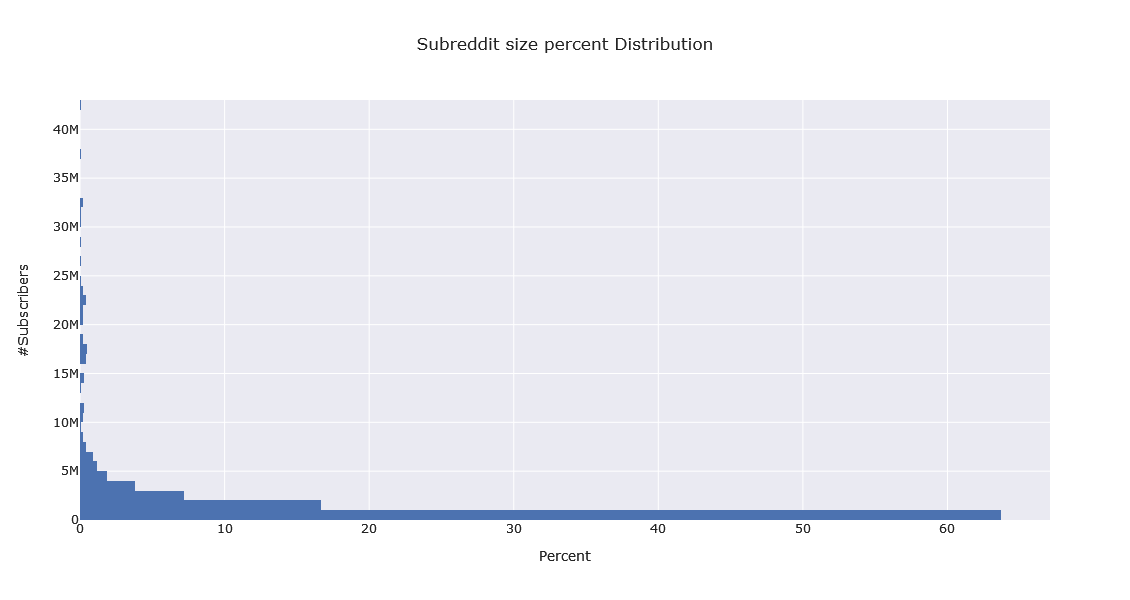

In [35]:
from plotly.graph_objs import Layout
layout = Layout(
    plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure()
fig.add_trace(go.Histogram(y=lst_n_subscribers, histnorm='percent'))
fig.update_yaxes(title='#Subscribers')
fig.update_xaxes(title='Percent')
fig.update_layout(template='seaborn', paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(width=800, height=600)
fig.update_layout(title='Subreddit size percent Distribution', title_x = 0.5)
fig.write_image('{}/{}'.format('output', 'subreddit_size_distribution.png'))

fig.show()

In [37]:
window_size = 5
overlap = 4
difference_between_values = 1

lst_avg_post_subscribers_day = []
lst_avg_growth_day = []
lst_avg_weighed_growth_day_up = []
lst_avg_weighed_growth_day_down = []
lst_weighted_subscribers = []
labels = []
samples = []

for name, stats in tqdm(subreddits_stats.items()):
    if stats.n_subscribers() is None:
        continue
        
    weighted_subscribers = (max_subscribers - stats.n_subscribers()) / (max_subscribers - min_subscribers)
    weeks_posts = posts_per_week(stats)
    weeks_subsribers = subsribers_per_week(stats)
    weeks_comments = comments_per_week(stats)
    weeks_growth =  growth_per_week(stats)


    weeks = sorted(list(set(weeks_posts.keys()).intersection(set(weeks_subsribers.keys())).intersection(weeks_comments.keys()).intersection(weeks_growth.keys())))
    sliding_window_weeks = sliding_window_overlap(weeks, window_size, overlap)
    filtered_weeks = [arr for arr in sliding_window_weeks if has_equal_differences(arr, difference_between_values)]

    if len(weeks) == 0:
        continue

    min_week = min(weeks)

    for sample_weeks in filtered_weeks:    
        sample = {}
        for index, week in enumerate(sample_weeks):
            sample['subreddit'] = name
            sample['week_{}'.format(index)] = week
            sample['n_posts_{}'.format(index)] = weeks_posts[week]
            sample['n_subsribers_{}'.format(index)] = weeks_subsribers[week]
            sample['n_comments_{}'.format(index)] = weeks_comments[week]
            sample['growth_{}'.format(index)] = weeks_growth[week]
            sample['wighted_growth_up_{}'.format(index)] = weeks_growth[week] * (1.05 ** (index + 1))
            sample['wighted_growth_down_{}'.format(index)] = weeks_growth[week] * (0.95 ** (index + 1))

        samples.append(sample)
    # avg_post_subscribers = post_per_subsribers_sum / len(days_s)


100%|██████████| 1074/1074 [00:22<00:00, 48.48it/s]


In [230]:
data = pd.DataFrame(samples)
data

,subreddit,week_0,n_posts_0,n_subsribers_0,n_comments_0,growth_0,wighted_growth_up_0,wighted_growth_down_0,week_1,n_posts_1,...,growth_3,wighted_growth_up_3,wighted_growth_down_3,week_4,n_posts_4,n_subsribers_4,n_comments_4,growth_4,wighted_growth_up_4,wighted_growth_down_4
0,legaladvice,2544,94.833333,537908,356.458333,0.022114,0.023220,0.021009,2545,129.791667,...,0.025062,0.030463,0.020413,2548,148.458333,601013,670.041667,0.030596,0.039049,0.023675
1,legaladvice,2545,129.791667,551249,613.791667,0.024548,0.025776,0.023321,2546,170.791667,...,0.030596,0.037190,0.024921,2549,144.375000,615374,633.416667,0.023659,0.030196,0.018307
2,legaladvice,2546,170.791667,568546,800.000000,0.030972,0.032520,0.029423,2547,136.625000,...,0.023659,0.028758,0.019270,2550,116.833333,627371,515.333333,0.019336,0.024678,0.014962
3,legaladvice,2547,136.625000,582943,611.750000,0.025062,0.026315,0.023809,2548,148.458333,...,0.019336,0.023503,0.015749,2551,187.125000,636514,810.500000,0.014485,0.018487,0.011208
4,legaladvice,2548,148.458333,601013,670.041667,0.030596,0.032126,0.029066,2549,144.375000,...,0.014485,0.017606,0.011798,2552,183.625000,650612,842.750000,0.021943,0.028006,0.016979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209132,india,2790,45.541667,1795343,510.708333,0.003648,0.003830,0.003465,2791,52.000000,...,0.004775,0.005804,0.003890,2794,26.375000,1836890,92.916667,0.006988,0.008918,0.005407
209133,india,2791,52.000000,1802522,510.791667,0.003992,0.004191,0.003792,2792,55.375000,...,0.006988,0.008493,0.005691,2795,27.291667,1845094,131.791667,0.004458,0.005689,0.003449
209134,india,2792,55.375000,1815419,533.708333,0.007133,0.007490,0.006777,2793,30.583333,...,0.004458,0.005418,0.003631,2796,25.375000,1852562,111.875000,0.004041,0.005157,0.003127
209135,india,2793,30.583333,1824106,132.166667,0.004775,0.005014,0.004537,2794,26.375000,...,0.004041,0.004911,0.003291,2797,19.875000,1853126,93.250000,0.000304,0.000389,0.000236


In [248]:
X_columns = [ column_name for i in range(window_size - 1) for column_name in ['week_{}'.format(i), 'n_posts_{}'.format(i), 'n_subsribers_{}'.format(i), 'n_comments_{}'.format(i), 'growth_{}'.format(i)]]#, 'wighted_growth_up_{}'.format(i), 'wighted_growth_up_{}'.format(i), 'wighted_growth_down_{}'.format(i)]]
y_columns = ['n_subsribers_4']
# y_columns = ['week_4', 'n_posts_4', 'n_comments_4', 'growth_4']
train_test_split = 0.8

X_train , y_train , X_test , y_test = [[], [], [], []]
for subreddit_name in data['subreddit'].unique():
    subreddit_samples = data.loc[data['subreddit'] == subreddit_name].reset_index()
    n_reddit_samples = len(subreddit_samples)
    subreddit_train = subreddit_samples.iloc[:int(n_reddit_samples * train_test_split)]
    subreddit_test = subreddit_samples.iloc[int(n_reddit_samples * train_test_split):]
    X_train += list(subreddit_train[X_columns].values.tolist())
    y_train += list(subreddit_train[y_columns].values.tolist())
    X_test += list(subreddit_test[X_columns].values.tolist())
    y_test += list(subreddit_test[y_columns].values.tolist())
    
 

In [249]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')

# Train the model
model.fit(X_train, y_train, verbose=0)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE
rmse  = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 397858.6433220687


In [311]:
subreddit_name = np.random.choice(data['subreddit'], 1)[0]
weeks_subsribers = subsribers_per_week(subreddits_stats[subreddit_name])
    
real_weeks = list(weeks_subsribers.keys())
real_subscribers = list(weeks_subsribers.values())

subreddit_data = data.loc[data['subreddit'] == subreddit_name].reset_index()
n_reddit_data = len(subreddit_data)
subreddit_to_predict = subreddit_data.iloc[int(n_reddit_data * train_test_split):]
idx = real_weeks.index(subreddit_to_predict.iloc[-1]['week_4'])
real_weeks = real_weeks[:idx + 1]
real_subscribers = real_subscribers[:idx + 1]
predict_subscribers = []
predict_weeks = []
for X_predict in list(subreddit_to_predict[X_columns].values.tolist()):
    predict_weeks.append(X_predict[X_columns.index('week_3')] + 1)
    predict_subscribers.append(model.predict(X_predict))

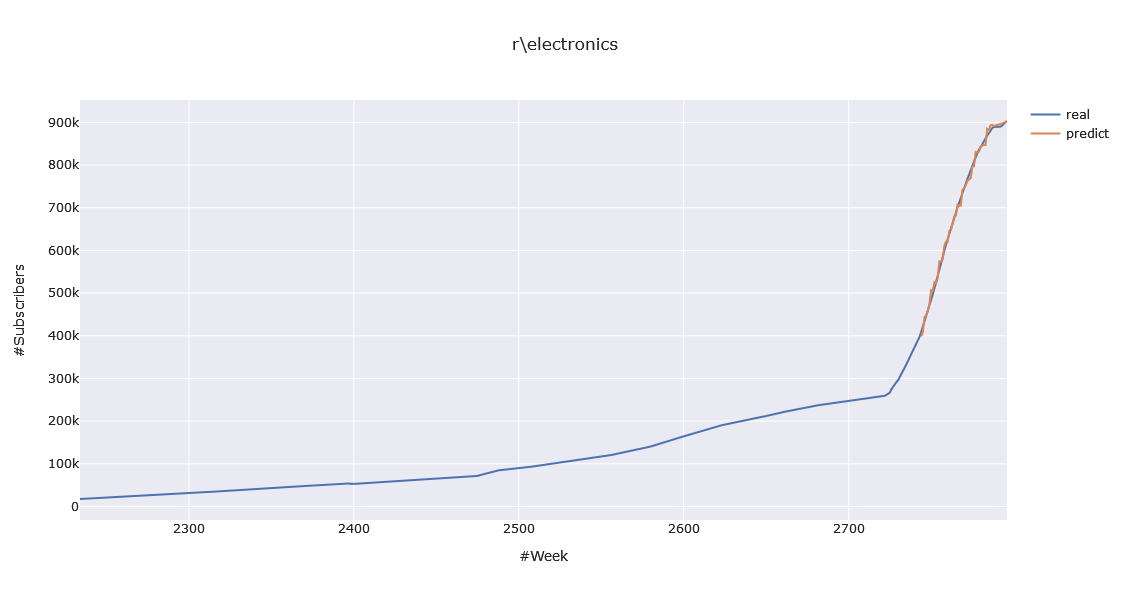

In [312]:

# Create a figure with multiple lines
fig = go.Figure()
for x_week, y_subscribers, label in ([real_weeks, real_subscribers, 'real'], [predict_weeks, predict_subscribers, 'predict']):
    fig.add_trace(go.Scatter(x=x_week, y=y_subscribers,
                    mode='lines',
                    name=label)
                 )
    
# Update the layout
fig.update_layout(title='r\\{}'.format(subreddit_name), xaxis_title='#Week', yaxis_title='#Subscribers', title_x = 0.5)
fig.update_layout(template='seaborn', paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(width=1200, height=600)
fig.write_image('{}/{}'.format('output', 'gaming_predicted.png'))
# Show the plot
fig.show()